### rows dropped
- if accessory rank is int, because accessories are not board games

### columns dropped  
- version
- compilation
- accessory
- implementation
- expansion (replaced by expansion count)
- thumbnail
- commerce
- honor (replaced by honor count)


### Data
[Kaggle link](https://www.kaggle.com/datasets/seanthemalloy/board-game-geek-database/)

[API description](https://boardgamegeek.com/wiki/page/BGG_XML_API2#toc3)

In [92]:
import numpy as np
import pandas as pd
import os
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [93]:
pd.set_option("display.max_rows", 500)

In [94]:
data_folder = "data"
file = os.path.join(data_folder, "BGGdata.csv")

In [95]:
if os.path.isfile(file):
    df = pd.read_csv(file)
else:
    os.system("unzip " + file + ".zip -d " + data_folder)
    df = pd.read_csv(file)

/var/folders/q8/v3k8g52x39qghrgmsnn0d84m0000gn/T/ipykernel_22542/3550345040.py:2: DtypeWarning: Columns (33,34,35,36,44,45,46,53,54,55,56,58,59,79,85,86,87,88,89,94,95,96,97,98,99,101,102,103,104,105,106,107,108,109,115,116,117,118,119,125,126,127,128,129,132,133,134,135,136,137,138,139,141,142,143,144,145,146,147,148,149,152,153,154,155,156,157,158,159,160) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


In [96]:
bgg_df = df.copy()
bgg_df.shape

(125537, 163)

# Parameters 

In [97]:
userrated_cutoff = 10 # line with less ratings get deleted

# Preprocessing
### deleting rows containing accessories, as well as row with too few ratings.
### Also we're using the bayes average as metric to be fitted instead of the plain average, dropping the later. The bayes average is corrected for amount of user ratings making the prediction more robust.

In [98]:
bgg_df2 = bgg_df[bgg_df["accessoryrank"].isna()]

In [99]:
bgg_df2 = bgg_df2[bgg_df2["usersrated"] >= userrated_cutoff]

In [100]:
bgg_df2.drop(columns="average", inplace=True)

## converting some categories to counts

In [101]:
# Honor count is more interesting than which honors
bgg_df2["hon_count"] = bgg_df2.filter(like="honor").count(axis=1)
# expansion count is more interesting than which expansions
bgg_df2["expan_count"] = df.filter(like="expansion").count(axis=1)


## dropping uninteresting columns 

In [102]:
def drop_columns(df:pd.DataFrame, search_string:list = None)-> None:
    '''
    Without search_string function prompts for search_string
    With search_string deleted columns whose title includes the search_string
    '''
    if search_string:
        search_string =  search_string if type(search_string) == str else "(?i)"+"|".join(search_string)
        df_temp = df.filter(regex=search_string)
        drop_column = df_temp.columns
        df.drop(columns=drop_column, inplace = True)
        return None

    search_string = input("filter string:")
    df_temp = df.filter(like=search_string)
    drop_column = df_temp.columns
    display(drop_column)
    
    answer = input("drop? yes/display/exit/")

    if answer == "yes":
        df.drop(columns=drop_column, inplace = True)
        drop_columns(df)
    elif answer == "display":
        display(df[drop_column].dropna().head())
        drop_columns(df)
    elif answer == "exit":
        return None
    else:
        drop_columns(df)

In [103]:
# dropping uninteresting columns
# designer and artist might be interesting, but there are just to many for statistical relevance
# minplaytime & maxplaytime seem redundant to playingtime and have a lot of mistakes
# rankings are directly derived from the score
drop_columns(bgg_df2, ["version","compilation","accessory", "implementation", "expansion", "thumbnail","commerce","honor", "artist", "designer", "minplaytime", "maxplaytime", "rank"])

In [104]:
bgg_df2.shape

(41597, 70)

# categorical variables
## exploring

In [105]:
def sum_value_counts(df:pd.DataFrame, columns:str):
    uniques = set()
    temp_df = pd.DataFrame()
    for column in df.filter(like=columns):
        uniques = uniques.union(set(df[column].unique()))
        temp_df[column] = df[column].value_counts()
    df_out = temp_df.sum(axis=1).sort_values(ascending=False)
    return df_out, uniques


Card Game                    29069.0
Expansion for Base-game      20237.0
Wargame                      18692.0
Children's Game              13242.0
Fantasy                      12723.0
Miniatures                   11612.0
Dice                         10414.0
Party Game                    9492.0
Science Fiction               9036.0
Abstract Strategy             8814.0
Fighting                      8598.0
Educational                   7807.0
Economic                      6833.0
Movies / TV / Radio theme     6688.0
Trivia                        6345.0
Print & Play                  6235.0
World War II                  5951.0
Animals                       5933.0
Humor                         5634.0
Action / Dexterity            5562.0
Adventure                     5281.0
Sports                        5126.0
Racing                        4635.0
Bluffing                      4025.0
Medieval                      4008.0
Deduction                     3823.0
Negotiation                   3566.0
W

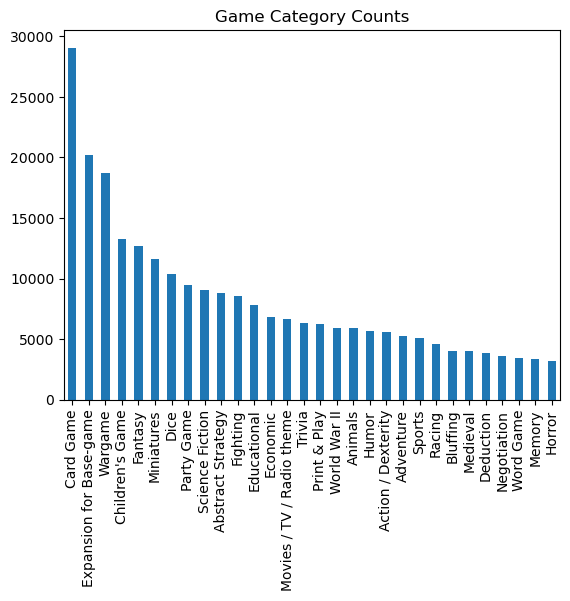

In [106]:
def plot_counts(df:pd.DataFrame ,columns:str, cut_off:int = 30,summary:bool = True):
    counts_df = sum_value_counts(df.drop(columns='familyrank'), columns)[0]
    counts_df.sort_index(ascending=False)
    if summary:
        display(counts_df.sort_values(ascending=True).sort_values(ascending=False).head(cut_off))
    counts_df.head(cut_off).plot.bar().set_title(f"game {columns} counts".title())

plot_counts(bgg_df,"category")

Dice Rolling                     30020.0
Hand Management                  16521.0
Roll / Spin and Move             15378.0
Set Collection                   12406.0
Variable Player Powers           12231.0
Card Drafting                     8643.0
Hexagon Grid                      7995.0
Cooperative Game                  7555.0
Simulation                        7301.0
Modular Board                     6822.0
Tile Placement                    6461.0
Action Points                     5693.0
Area Majority / Influence         5168.0
Point to Point Movement           4979.0
Grid Movement                     4948.0
Memory                            4912.0
Simultaneous Action Selection     4886.0
Auction/Bidding                   4334.0
Area Movement                     4254.0
Trading                           3830.0
Player Elimination                3756.0
Deck, Bag, and Pool Building      3741.0
Take That                         3406.0
Team-Based Game                   3369.0
Pattern Building

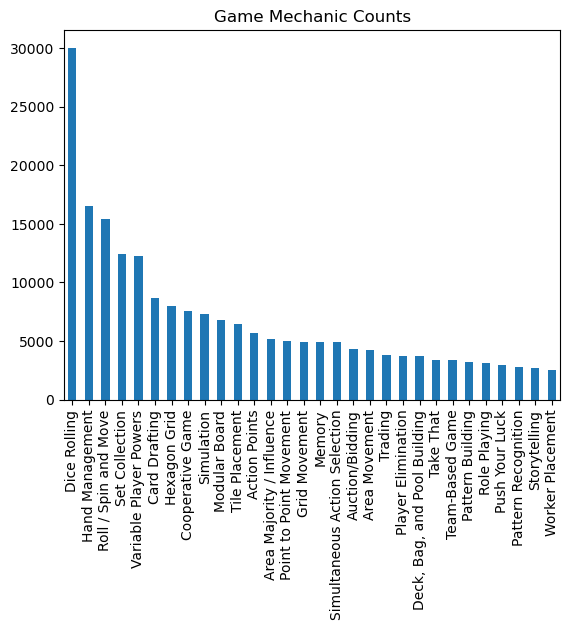

In [107]:
plot_counts(bgg_df,"mechanic")

Wargames              9416.0
Abstract Games        4613.0
Children's Games      3945.0
Strategy Games        2564.0
Family Games          2202.0
Thematic Games        1451.0
Party Games            639.0
Customizable Games     619.0
dtype: float64

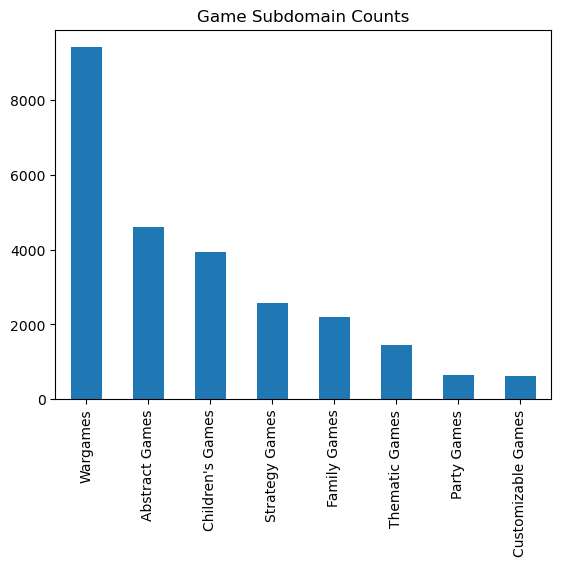

In [108]:
plot_counts(bgg_df,"subdomain")

In [109]:
all_the_wargames_df = bgg_df[(bgg_df.filter(like="subd") == "Wargames").any(axis=1)]

In [110]:
all_the_wargames_df.filter(like="year").value_counts()

yearpublished
2008.0           445
2007.0           400
2009.0           386
2005.0           363
2006.0           342
2004.0           316
2010.0           274
2003.0           264
2015.0           234
2012.0           228
2001.0           217
2002.0           211
2017.0           207
2013.0           204
2016.0           201
2014.0           200
2011.0           192
1992.0           175
1983.0           173
1998.0           171
2000.0           168
1999.0           166
1981.0           163
1997.0           162
1995.0           159
2018.0           157
1979.0           152
1994.0           149
1980.0           145
1993.0           144
1986.0           142
1977.0           137
1991.0           135
1984.0           134
1976.0           131
1985.0           131
1982.0           130
2019.0           130
1975.0           125
1978.0           125
1996.0           125
1987.0           120
1990.0           114
1988.0           105
1989.0           104
2020.0            69
1973.0            69

## reducing categories

1. misc category
1. aggregating similar categories *seems like a lot of work, let's try if misc is enough * 
    1. mech
        1. worker placement
        1. auction
    1. categ
        1. america wars
    1. honor
        1. count/delete nominations * a LOT of work*
        1. count awards

## functions for creating dummy variables
1. mechanic
1. subdomain
1. family
1. category
1. publisher



# Wargames

Text(0.5, 1.0, 'Counts by years')

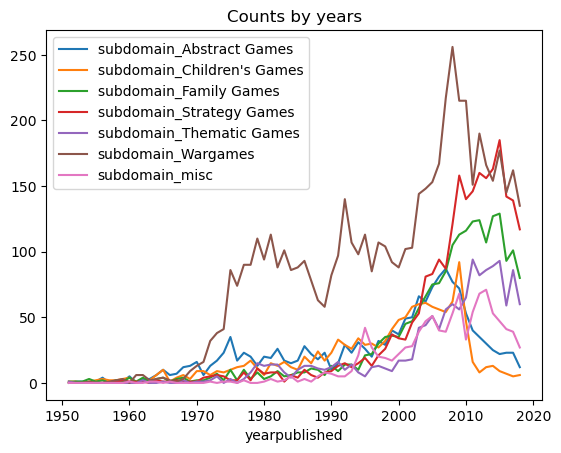

In [111]:
subdomains_df, _, _ = aggregate_mlb_clean(bgg_df2, "subdomain")


subdomains_df[(subdomains_df["yearpublished"] > 1950) & (subdomains_df["yearpublished"] < 2019)].filter(regex="sub|year").groupby("yearpublished").sum().plot().set_title("Counts by years")

In [112]:
def drop_one_hot_and_aggregate(df:pd.DataFrame, cutoff_type:str, param:int, agg:bool) -> pd.DataFrame:
    bools = None
    if cutoff_type == "min_freq":
        bools = (df.sum() < param).values
        df_out1 = df[df.columns[~bools]]
    agg_array = df[df.columns[bools]].sum(axis=1) if agg else None
    return df_out1, agg_array

In [113]:
def aggregate_mlb_clean(df:pd.DataFrame, column_search_str:str, misc:tuple[str,int,bool] = ("min_freq",1000,True)) -> tuple[pd.DataFrame,MultiLabelBinarizer,np.ndarray]:
    '''
    aggregate several columns of the same multi-label variable in one column as lists, one hot encode it and deleted superfluous columns

    df: input dataframe
    misc: Da muss ich mir noch überlegen welche Arten ich will. Top x? x% ? Cutoff wenn zuviele?
    '''
    df = df.copy()
    df[column_search_str] = df.filter(regex= column_search_str + "[0-9]").fillna("NaN").values.tolist()
    mlb = MultiLabelBinarizer()
    mlb_array = mlb.fit_transform(df[column_search_str])
    drop_columns(df, column_search_str)
    classes = mlb.classes_
    columns = column_search_str + "_" + classes
    df2 = pd.DataFrame(mlb_array, columns= columns, index=df.index).drop(columns=column_search_str + "_" +"NaN")
    df2, agg_array = drop_one_hot_and_aggregate(df2, *misc)
    if agg_array is not None:
        df2[column_search_str + "_misc"] = agg_array
    df_out = df.join(df2)
    return df_out, mlb, mlb_array

# Regression

In [114]:
# Mean function
fill_mean = lambda col: col.fillna(col.mean())

def clean_fit_linear_mod(df, response_col, cat_cols, test_size=.3, rand_state=42):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column 
    cat_cols - list of strings that are associated with names of the categorical columns
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    #Drop columns with all NaN values
    df = df.dropna(how='all', axis=1)

    

    # creating dummy variables
    for col in cat_cols:
        df, _, _ = aggregate_mlb_clean(df, col)

    df = df.select_dtypes(exclude="object")
     # Fill the mean
    df = df.apply(fill_mean, axis=0)

    #Split into explanatory and response variables
    X = df.drop(response_col, axis=1)
    y = df[response_col]
    columns = X.columns
   
    #scaling X
    scaler = MinMaxScaler()
    scaled_X = scaler.fit_transform(X)
    
    
    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=test_size, random_state=rand_state)

    lm_model = LinearRegression() # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    #Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test, columns

In [115]:
#Test your function with the above dataset
cat_cols_lst = ["category", "mechanic", "subdomain", "family", "publisher"]
test_score, train_score, lm_model, X_train, X_test, y_train, y_test, columns = clean_fit_linear_mod(bgg_df2, 'bayesaverage', cat_cols_lst)

In [116]:
print(f"Test score  : {test_score:.2}\nTrain score : {train_score:.2}")

Test score  : 0.67
Train score : 0.69


In [124]:
def coef_weights(coefficients, X_train, columns):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

In [125]:
test_score, train_score, lm_model, X_train, X_test, y_train, y_test, columns = clean_fit_linear_mod(bgg_df2, 'bayesaverage', cat_cols_lst)
coef_df = coef_weights(lm_model.coef_, X_train, columns)

print(f"Test score  : {test_score:.2}\nTrain score : {train_score:.2}")
coef_df["%"] = 100* coef_df.abs_coefs/coef_df.abs_coefs.sum()
coef_df.head(10)

Test score  : 0.67
Train score : 0.69


,est_int,coefs,abs_coefs,%
1,usersrated,-15.246147,15.246147,35.012494
7,owned,12.599758,12.599758,28.935113
11,numcomments,5.640496,5.640496,12.953295
9,wanting,4.731459,4.731459,10.865709
8,wishing,-1.704649,1.704649,3.914695
3,numweights,-0.857727,0.857727,1.969753
10,trading,-0.450412,0.450412,1.034362
13,hon_count,0.351987,0.351987,0.808332
12,yearpublished,0.227516,0.227516,0.522487
6,playingtime,-0.219299,0.219299,0.503615


The leading features are "usersrated", "owned", "numcomments", "wanting", "wishing", "numweights", "trading".

|feature|description|
|----|----|
|usersrated|How many users rated the game.|
|owned|How many users own the game.|
|numcomments|How many users commented on the game.|
|wanting|How many users want to buy the game.|
|wishing|How many users have the game on their wish list.|
|numweights|How many users rated the games complexity.|
|trading|How many users are selling the game.|

It's fairly obvious that the underlaying factor is user engagement, which basically comes down to recommendations from the community.<br>As avid board gamer, I already know that talking to other aficionados is a great way to find new games, so let's get rid of those features and see if we can uncover something deeper.

In [121]:
bgg_df3 = bgg_df2.drop(columns=["usersrated", "owned", "numcomments", "wanting", "wishing", "numweights", "trading"])
test_score, train_score, lm_model, X_train, X_test, y_train, y_test, columns = clean_fit_linear_mod(bgg_df3, 'bayesaverage', cat_cols_lst)

In [122]:
coef_df2 = coef_weights(lm_model.coef_, X_train, columns)

print(f"Test score  : {test_score:.2}\nTrain score : {train_score:.2}")
coef_df2["%"] = 100*coef_df2.abs_coefs/coef_df2.abs_coefs.sum()
coef_df2.head(10)

Test score  : 0.51
Train score : 0.52


,est_int,coefs,abs_coefs,%
6,hon_count,1.100560,1.100560,23.884604
5,yearpublished,0.428624,0.428624,9.302100
89,publisher_misc,0.271947,0.271947,5.901850
0,stddev,-0.271423,0.271423,5.890481
76,subdomain_Strategy Games,0.260310,0.260310,5.649298
72,mechanic_misc,0.221675,0.221675,4.810837
7,expan_count,0.221607,0.221607,4.809374
77,subdomain_Thematic Games,0.155456,0.155456,3.373735
1,weight,0.124508,0.124508,2.702103
82,family_Players: Games with Solitaire Rules,0.095018,0.095018,2.062099
